<a href="https://colab.research.google.com/github/WaterPurify/Alpaco_Bootcamp/blob/main/2_Natural%20Language%20%26%20Speech%20Recognition/Team_project/Code/FORS_%EC%A1%B0%EC%98%81%EC%88%98_version5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whisper AI fine-tuning 하는 코드

WhisperAI_fine_tune_version6

## 🤗 Transformer를 적용한 다국어 자동 음성 (ASR)을 Whisper에 fine-tuning


*   Step-by-step guide on how to fine-tune Whisper for any multilingual ASR dataset using Hugging Face 🤗 Transformers.
*   For a more in-depth explanation of Whisper, the Common Voice dataset and the theory behind fine-tuning, the reader is advised to refer to the blog post.[blog post](https://huggingface.co/blog/fine-tune-whisper).



### Introduction



*   Whisper
    * A pre-trained model for automatic speech recognition (ASR) published in September 2022 by the authors Alec Radford et al. from OpenAI.
    *  Pre-trained on a vast quantity of labelled audio-transcription data, 680,000 hours to be precise
    * Demonstrate a strong ability to generalise to many datasets and domains

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

* Five configurations of varying model sizes.
    1. The smallest four trained on either English-only or multilingual data.
    2. The largest checkpoints  multilingual only.
    
* All 11 of the pre-trained checkpoints are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper).

* The checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


* Fine-tune the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
* Train and evaluate our system on a low-resource language
taken from the [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
dataset.
* 8 hour fine-tuning of Whisper AI can acheive strong performance in our Korean language for old peaple.

### Prepare Environment


1. GPU setting
    *  click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

* Employ poplular Pytohn packages

    1. Use `datasets[audio]` to download and prepare our training data
    2. `Transformers` and `accelerate` to load and train our Whisper model
    3. `soundfile` package to pre-process audio files
    4. `evaluate` and `jiwer` to assess the performance of our model
    5. `tensorboard` to log our metrics
    6.  `gradio` to build a
flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

In [ ]:
#spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
!pip install typer==0.9.1


In [ ]:
#tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.

!pip install tensorboard==2.15.0

In [ ]:
#weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
!pip install weasel==0.3.4

* Upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training.

* The Hub provides:
    - Integrated version control: you can be sure that no model checkpoint is lost during training.
    - Tensorboard logs: track important metrics over the course of training.
    - Model cards: document what a model does and its intended use cases.
    - Community: an easy way to share and collaborate with the community!

- Linking the notebook to the Hub is straightforward  

* Entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [ ]:
# Huggingface 로그인
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset




* Using 🤗 Datasets, download and prepare data

    1. Ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_12_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_12_0).

    2. 5 hours of korean dataset is considered low-resource, so we decided to use dataset from [AI hub](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=123) which has more than 1000 hours with 2000 speakers.


In [ ]:
# 학습이랑 테스트 데이터 불러오기
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_12_0", "ko", split="test", use_auth_token=True)

print(common_voice)



* Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`).

    * Common Voice contains additional
      metadata information, such as `accent` and `locale`, which we can disregard for ASR.

* For only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [ ]:
# Common_voice안에 필요없는 column 제거하기
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

print(common_voice)

## Prepare Feature Extractor, Tokenizer and Data



ASR pipeline de-composed into three-stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.



#### Load WhisperFeatureExtractor

The whisper feature extractor with two operations:

1. Pads/truncate the audio inputs to 30s: any audio inputs shorter than 30s padded to 30s with silence(zeros), and those longer than 30s truncated to 30s

2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

Load the feature extractor from the pre-trained checkpoint with the default values:

In [ ]:
# WhisperFeatureExtractor를 통해서 pre-traine checkpoint 가져오기
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

#### Load WhisperTokenizer

* Outputs a seqeuence of _token ids_
* Tokenizer maps each of these token ids to their corresponding text string
* For Korean, load the pre-trained tokenizer and use it for fine-tuning without any further modifications
    
    * Specify the target language and the task

    *  The tokenizer to prefix the language and task tokens to the start of encoded label sequences:

In [ ]:
# WhisperTokeinzer를 통해서 원하는 task 언어를 토큰화 진행하기
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")

#### Combine To Create A WhisperProcessor



* To simplify using the feature extractor and tokenizer
 * Wrap both into a single WhisperProcessor class
    
 * Inherits from the WhisperFeatureExtractor and WhisperProcessor

 * Can be used on the audio inputs and model predictions as required

* Keep track of two objects during training: the processor and the model:

In [ ]:
# WhisperProceesor는 작업하는 언어와 작업을 설정하기
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Korean", task="transcribe")

#### Prepare Data

Print the first example of the Common Voice dataset

In [ ]:
print(common_voice["train"][0])

* Input audio sampled at 48 kHz -> downsample to 16kHz before pass to the Whisper feature extractor
    
    * 16 kHz the sampling rate expected by the Whisper model

* Using dataset's [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column) method => Able to set the audio inputs to the correct sampling rate

    * Resample audio sample _on the fly_ the first time that they are loaded

In [ ]:
# Cast column 방법을 통해 원하는 sampling rate로 설정 가능
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Now write a function to prepare our data ready for the model:

 1. Load and resample the audio data by calling `batch["audio"]`.
 2. Use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array
 3. Encode the transcriptions to label ids through the use of the tokenizer.

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

* Apply the data prepartation function  to all our training examples using dataset's `.map` method

    * `num_proc`: How many CPU cores to use (`num_proc` > 1 will enable multiprocessing)





In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

#### Training and Evaluation



#####Training pipeline






The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) do much of the heavy lifting for us

 - Load a pre-trained checkpoint: Need to load a pre-trained checkpoint and configure it correctly for training.

 - Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model

 - Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (CER)](https://huggingface.co/metrics/cer) metric. We need to define a `compute_metrics` function that handles this computation

 - Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule

 After fine-tuned the model, evaluate it on the test data to verify it on the test data to verfify if we trained correlty to transcribe speech in Korean.

#### Load a Pre-Trained Checkpoint

* Use the pre-trained Whisper `small` checkpoint (the weights for which we need to load from the Hugging Face Hub)

In [ ]:
# 이 모델은 조건부 생성(conditional generation)을 위해 설계되었으며, 주어진 입력에 대해 텍스트를 생성하는 작업을 수행
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

#### Diable the automatic language detection task



*  set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config

* set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None (Default setting)

In [ ]:
# model.generation_config.language = "hindi"
# model.generation_config.task = "transcribe"

# model.generation_config.forced_decoder_ids = None

##### Define a Data Collator



* Sequence-to-sequence speach model: the `input_features` and `labels` independently

 * the  `input_features` by the feature extractor
 * the `labels` by the tokenizer

* The `input_features` padded to 30s and converted to a log-Mel spectrogram of fixed dimension by action of the feature extractor

* Convert the `input_features`
to batched PyTorch tensors
 * Use the feature extractor's `.pad` method with `return_tensors=pt`

* The `labels` un-padded
 1. Pad the sequences to the maximum length in the batch using the tokenizer's `.pad` method
 2. Padding tokens replaced by  `-100` :**not** taken into account when computing the loss
 3. Cut the BOS (Beginning of sentence) token from the start of the label sequence (append it later during training)



In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

#### Evaluation Metrics



* Use the word error rate (CER) metric, the 'de-facto' metric for assessing ASR systems. For more information, refer to the CER [docs](https://huggingface.co/metrics/cer).

In [ ]:
import evaluate

metric = evaluate.load("cer")

* Define a function that takes our model predictions and returns the CER metric
    * Called
     `compute_metrics`, first replaces `-100` with the `pad_token_id` in the `label_ids` (undoing the step we applied in the data collator to ignore padded tokens correctly in the loss).

1. Decodes the predicted and label ids to strings
2. Computes the CER between the predictions and reference labels:

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

#### Define the Training Configuration


* Define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
import accelerate

accelerate.__version__

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ko",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    push_to_hub=True,
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`

Forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

Save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [ ]:
processor.save_pretrained(training_args.output_dir)

#### Training



* Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab


For prevent the training without interrupted due to inactivity in Colab

* Insert the code into the console of the this tab (_right mouse click_-> _inspect_ -> _Console tab_ -> _insert code_)

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for given configuration: approximately 15.8 GB.
 * Depending on the GPU allocated to the Google Colab, Encounter a CUDA `"out-of-memory"` error when launching training => reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

* Gradient Accumulation 방법은 미니 배치를 통해 구해진 gradient를 n-step동안 Global Gradients에 누적시킨 후, 한번에 업데이트하는 방법입니다. 예를 들어서 현재 batch size가 16이고 n-step 값이 16이면 batch size 16으로 16번의 gradient 축적을 통해서 한번의 forward/back propagation을 실행한다. 이렇게 되면 실제로 배치사이즈 256을 사용한 효과를 얻을 수 있으나, 훈련시간이 매우 길어질 수 있다는 단점

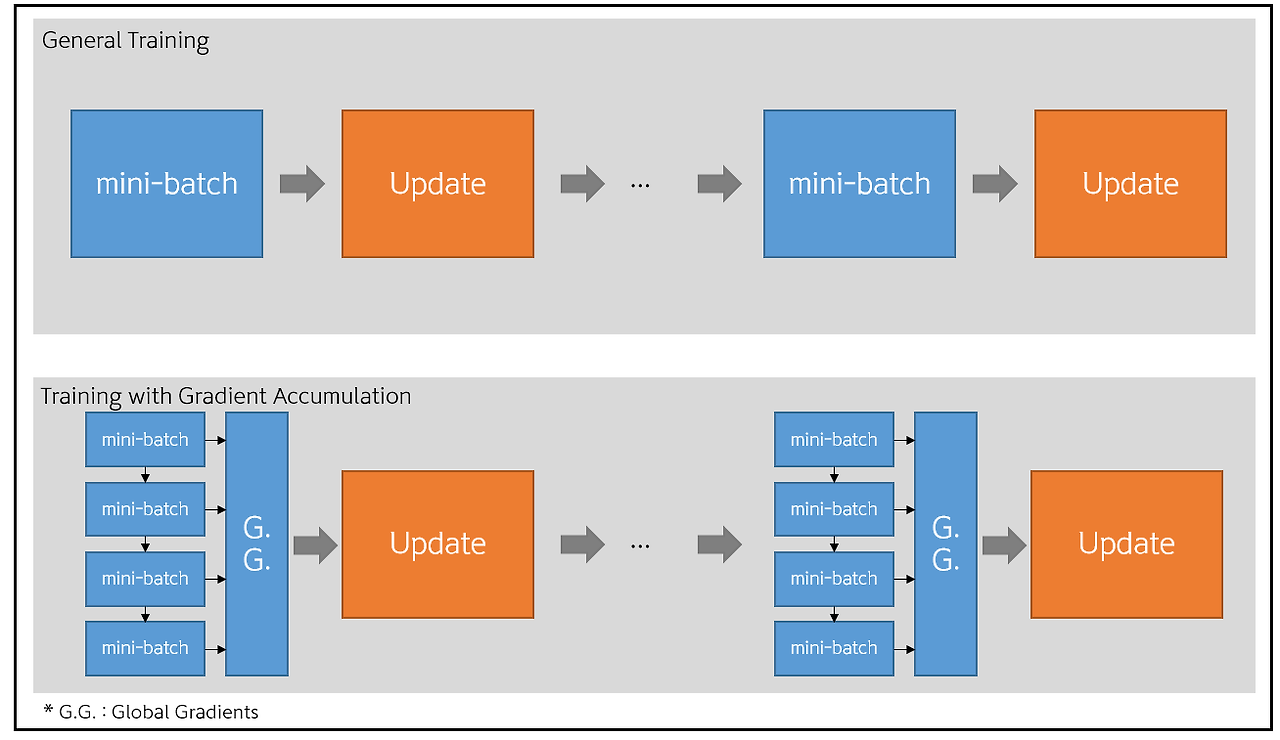

Launch training with simple code below

In [ ]:
trainer.train()


* Able to make our model more accessible on the Hub with appropriate tags and README information.

* Able can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_12_0",
    "dataset": "Common Voice 12.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: ko, split: test",
    "language": "ko",
    "model_name": "Whisper Small Ko - Youngsu Jo",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

Training results now be uploaded to the Hub
* Excecute the `push_to_hub` command and save the preprocessor object we created:

In [ ]:
trainer.push_to_hub(**kwargs)

### Building a Demo



After fine-tuning our model, build a demo to show off its ASR capabilities!

* Make use of 🤗 Transformers
`pipeline`
    * Take care of the entire ASR pipeline, right from pre-processing the audio inputs to decoding the model predictions

* Running the example below
    * Generate a Gradio demo where we
     can record speech through the microphone of our computer and input it to our fine-tuned Whisper model to transcribe the corresponding text:

In [ ]:
!pip install gradio

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="ZeroWater93/whisper-small-ko")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
# 녹음한 파일
iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Small Korean",
    description="Realtime demo for Korean speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

In [ ]:
# 파일 업로드
iface = gr.Interface(
    fn=transcribe,
    inputs=gr.File(type="filepath", label="Upload Audio File"),
    outputs="text",
    title="Whisper Small Korea",
    description="Realtime demo for Korea speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

#  Whisper AI fine-tuning의 경량화 버전

fasterWhisper_w_PEFT_finetune (quantization과 parameter efficient fine-tuning 기법)

## LoRA (Low Rank Adaptation) 와 PEFT (Paramater Efficient Fine Tuning)를 적용한 Larger Whisper fine-tuning ⚡️


* 소비자 GPU의 VRAM이 8GB 미만인 환경에서도 full-finetuning과 유사한 성능을 제공함
*  🤗 Transformers and PEFT 모델과 Common Voice 13.0 dataset를 사용하여 Whisper fine-tune하는 과정 설명함
* PEFT와 bitsandbytes를 활용하여 무료 T4 GPU(16GB VRAM)를 사용하여 whisper-large-v2 체크포인트를 원활하게 학습

### 왜 Parameter Efficient Fine Tuning [PEFT](https://github.com/huggingface/peft)를 사용해야 되는가?


* 모델 사이즈 증가로 fine tuning하는 것이 계산 복잡성 증가와 메모리 사용량 증가
    * 예를 들어, Whisper-large-v2 모델을 완전한 미세 조정을 위해 약 24GB의 GPU VRAM이 필요하며, 각 미세 조정된 모델은 약 7GB의 저장 공간을 필요함

    * 제한적인 환경에서 bottleneck 발생하고 원하는 결과를 얻기 힘듦
* PEFT
    * 효과적으로 parameter를 줄여서 fine tuning 속도 개선
    * 목적: 병목 현상을 해결
    * 접근법(예: 저수준 적응): 사전 훈련된 모델의 대부분의 매개변수를 동결시키면서 추가 모델 매개변수의 일부만 미세 조정하여 계산 및 저장 비용 크게 줄임
        * 대규모 모델의 전체 미세 조정 중 관찰되는 catastrophic forgetting 문제를 극복할 수 있음


#### LoRA가 무엇인가?

* PEFT에서 여러 매개변수 효율적인 기술을 기본으로 제공
    * 그 중 하나인 Low Rank Adaptation (LoRA)
        * 사전 훈련된 모델 가중치를 동결하고 Transformer 아키텍처의 각 레이어에 훈련 가능한 랭크 분해 행렬을 삽입 (High Rank 즉 많은 연결이 되어 있는 것들보다 연결이 적은 Low Rank로 만들어서 계산량을 줄임)
            * Downstream 작업에 대한 훈련 가능한 매개변수 수가 크게 감소

#### 통계로 보는 PEFT 효과


* Full fine-tuning of Whisper-large-v2 checkpoint Vs. PEFT 적용 모델

    1. GPU VRAM이 8GB 미만인 환경에서 16억 개의 매개변수를 가진 모델을 미세 조정 🤯
    2. 훨씬 적은 수의 훈련 가능한 매개변수를 사용하여 거의 5배 더 큰 배치 크기를 사용 가능 📈
    3. 생성된 체크포인트는 원본 모델의 크기의 1%인 약 60MB 🚀
* 기존 🤗 transformers Whisper에서 변형이 많이 되지 않았음

    



### 환경설정


* Python package->Whisper 모델 fine tuning하기 위해 사용
  * `datasets`:학습 데이터를 다운로드하고 준비
  * `transformers`: Whisper 모델을 로드하고 훈련
  * `librosa`: 오디오 파일을 전처리
  * `evaluate` &  `jiwer`:모델의 성능을 평가
  * `PEFT`, `bitsandbytes`, `accelerate`: LoRA로 모델과 fine-tuning

In [ ]:
!pip install -q transformers datasets librosa evaluate jiwer gradio bitsandbytes accelerate
!pip install -q git+https://github.com/huggingface/peft.git@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 

In [ ]:
!pip install typer==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 4.28.3 requires typer<1.0,>=0.12; sys_platform != "emscripten", but you have typer 0.9.1 which is incompatible.



* GPU 확보
    * Google Colab Pro: V100 또는 P100 GPU가 할당
* GPU 확보 방법
    * 런타임 -> 런타임 유형 변경
    * None -> GPU 변경
* GPU 할당 확인

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 30 05:55:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Colab에서 제공하는 GPU사용

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


* 학습 중 모델 체크포인트를 직접 Hugging Face Hub에 업로드하는 것을 강력히 권장
 * Hub를 사용하면 다음과 같은 기능을 제공:

 1. 통합된 버전 관리: 훈련 중에 어떠한 모델 체크포인트도 손실되지 않음
 2. Tensorboard 로그: 훈련 과정에서 중요한 지표를 추적
 3. 모델 카드: 모델이 무엇을 하고 의도된 사용 사례를 문서화
 4. 커뮤니티: 커뮤니티와 쉽게 공유하고 협업

* Hub에 연결
 * 프롬프트에서 Hub 인증 토큰을 입력:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Whisper 모델 checkpoint와 task 설정

In [ ]:
model_name_or_path = "openai/whisper-large-v3"
task = "transcribe"



데이터셋 디테일을 설정 (언어)

In [ ]:
dataset_name = "mozilla-foundation/common_voice_12_0"
language = "Korean"
language_abbr = "ko" # Short hand code for the language we want to fine-tune

## 데이터셋 올리기



* Huggingface Dataset 사용
 * 적은 코드로 Common Voice의 데이터를 다운로드하고 준비

* 확인 절차
 1. Hugging Face Hub의 이용 약관을 수락했는지 확인:[mozilla-foundation/common_voice_12_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_12_0)
 2. 데이터셋에 액세스하고 로컬로 데이터를 다운로드

* 학습+검증 데이터셋/테스트 데이터셋 분리

In [ ]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset(dataset_name, language_abbr, split="test", use_auth_token=True)

print(common_voice)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_12_0 contains custom code which must be executed to correctly load the dataset. You 

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 94it [00:00, 92593.84it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 30it [00:00, 95397.36it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 29it [00:00, 77622.73it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 1009it [00:00, 97905.26it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 38it [00:00, 34100.03it/s]
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_12_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_12_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 124
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 29
    })
})


* 일반적인 ASR(음성 인식) 데이터셋
    * 입력 오디오 샘플(오디오)과 해당되는 텍스트(문장)만 제공
* Common Voice
    * ASR에는 필요하지 않은 악센트와 로케일과 같은 추가 메타데이터 정보가 포함
    * 일반적인 용도로 사용하고 미세 조정을 고려하기 위해 메타데이터 정보 무시

In [ ]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 124
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 29
    })
})


### 특성 추출기(Feature Extractor), 토크나이저(Tokenizer), 그리고 데이터준비



ASR 파이프라인 세 단계로 분해:

1. Raw 오디오 입력을 전처리하는 특정 추출기
2. 시퀀스 간 매핑을 수행하는 모델
3. 모델 출력을 텍스트 형식으로 후처리하는 tokenizer


* Whisper
    * [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)와 [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)로 구성



In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


* WhisperProcessor 클라스
    * 특성 추출기와 토크나이저를 사용하기 위해 두 가지를 모두 합칩
    * 필요에 따라 오디오 입력 및 모델 예측에 사용 가능

* 학습 중에 두 개의 객체만 추적 필요: 프로세서와 모델

In [ ]:
# WhisperProceesor는 작업하는 언어와 작업을 설정하기
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3", language="Korean", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### 데이터 준비



Common Voice 데이터셋의 첫 번째 예제를 출력하여 데이터의 형식을 살펴봄

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dadcc290d826ab16f676d936c103a5a96d53aee994c8c9215b0b57f603640bc6/ko_train_0/common_voice_ko_35844026.mp3', 'array': array([-7.38964445e-13, -3.18323146e-12, -4.09272616e-12, ...,
       -3.05185895e-05, -1.81265241e-05, -6.66307460e-06]), 'sampling_rate': 48000}, 'sentence': '골짜구니가 울리도록 커다랗게 기침을 하였다.'}


* Whisper 모델 샘플링
    * 입력 오디오는 48 kHz 새플링
    * Whisper feature extractor에 전달하기 위해서 16 kHz로 다운샘플 진행
* 샘플링 속도 설정
    * Dataset의 [`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column) 방법 사용: 오디오 입력을 올바른 샘플링 속도로 설정
    * 오디오를 변경하는 것이 아니라 오디오 샘플을 실시간으로 받을 수 있도록 함


In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))


Common Voice 데이터셋에서 첫 번째 오디오 샘플을 다시로드하면 원하는 샘플링 속도로 다시 샘플링

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/dadcc290d826ab16f676d936c103a5a96d53aee994c8c9215b0b57f603640bc6/ko_train_0/common_voice_ko_35844026.mp3', 'array': array([-1.27329258e-11, -5.45696821e-12,  7.27595761e-12, ...,
       -1.77163565e-05, -4.15709401e-05, -3.01608670e-05]), 'sampling_rate': 16000}, 'sentence': '골짜구니가 울리도록 커다랗게 기침을 하였다.'}



* 모델에 맞게 데이터를 준비하는 함수:

1. batch["audio"]를 호출하여 오디오 데이터를 로드하고 다시 샘플링. 🤗 Datasets는 필요한 모든 재샘플링 작업을 실시간으로 수행
3. Feature extractor를 사용하여 1차원 오디오 배열에서 로그 멜 스펙트로그램 입력 특성을 계산
3. Tokenizer를 사용하여 transcripts를 레이블 ids로 인코딩


In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

* 데이터 준비 함수
    * 데이터셋의 .map 메서드를 사용하여 모든 학습 예제에 적용 가능
    * num_proc: 몇 개의 CPU 코어를 사용할 지를 지정,num_proc를 1보다 크게 설정하면 다중 처리가 활성화 (다중 처리로 .map 메서드가 중단되는 경우 num_proc=1로 설정하고 데이터셋을 순차적으로 처리)

* Dataset의 사이즈에 따라서 20~30 분 정도 걸림


In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

# common_voice = common_voice.map(
#     prepare_dataset,
#     remove_columns=common_voice.column_names["train"],
#     num_proc=2,
#     fn_kwargs={"feature_extractor": feature_extractor, "tokenizer": tokenizer}
# )


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/124 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/29 [00:00<?, ? examples/s]

In [ ]:
common_voice["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 124
})

### 학습 및 검증




* 훈련 파이프라인
* [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)가 대부분의 작업을 처리:


1. 데이터 collator 정의: 데이터 콜레이터는 우리가 전처리한 데이터를 가져와 모델에 사용할 수 있는 PyTorch 텐서로 준비
2. 평가 지표: 평가 중에는 모델을 글자 오류율  [word error rate (CER)](https://huggingface.co/metrics/cer)지표를 사용하여 평가
3. 사전 훈련된 체크포인트 load: 사전 훈련된 체크포인트를 로드하고 훈련을 위해 올바르게 구성
4. 훈련 구성 정의: 🤗 Trainer가 훈련 스케줄을 정의에 사용

* 미세 조정한 후에는 테스트 데이터에서 모델을 평가하여 한국어 음성을 올바르게 transcribe


#### Data Collator 정의



* 시퀀스-투-시퀀스 음성 모델의 데이터 콜레이터
    * Input_features와 labels를 독립적으로 처리 차별화
    
    - Input_features: feature extractor에 의해 처리
    - labels: tokenizer에 의해 처리

* Input_features는 이미 30초로 패딩되어 있고 특성 추출기에 의해 고정된 차원의 로그 멜 스펙트로그램으로 변환. 따라서 우리가 해야 할 일은 input_features를 배치 처리된 PyTorch 텐서로 변환

* labels는 패딩되지 않음 먼저 배치 내에서 최대 길이에 맞게 시퀀스를 패딩하고, tokenizer의 .pad 메서드를 사용하여 시퀀스를 패딩 패딩 토큰은 손실을 계산할 때 고려되지 않도록 -100으로 대체. 그런 다음 레이블 시퀀스의 시작에서 BOS 토큰을 잘라서 훈련 중에 나중에 이를 추가

* 이전에 정의한 WhisperProcessor를 활용하여 특성 추출기 및 토크나이저 작업을 모두 수행 가능

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        # Torch tensor의 형태로 출력하기 위해 ->Dict[str,torch.Tensor] 사용하였습니다
        #
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways

        # 시작 토큰을 재거하는 코드
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Data collator 초기화 진행

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

#### 평가 지표


* ASR 시스템을 평가하기 위한 '사실상의' 지표인 한 단어 오류율(CER) 메트릭을 사용
* 더 많은 정보는 [문서](https://huggingface.co/metrics/cer)를 참조. 우리는 🤗 Evaluate에서 CER 메트릭을 로드

In [ ]:
import evaluate

metric = evaluate.load("cer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

#### Pre-trained 모델 로드

* 사전 훈련된 Whisper 체크포인트를 로드
    * 이 작업은 🤗 Transformers를 사용하여 매우 간단



* 모델의 메모리 사용량을 줄이기 위해 모델을 8비트로         
    * 모델을 1/4 정밀도(32비트와 비교했을 때)로 양자화하여 성능 손실을 최소화 [here](https://huggingface.co/blog/hf-bitsandbytes-integration)

In [ ]:
from transformers import WhisperForConditionalGeneration

# Qunatization: 보통 weight들은 float32로 되어 있는데 int로 바꿈으로써 성능 최적화

model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path, load_in_8bit=True, device_map={"":0})

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

#### 모델의 후처리


1. 훈련을 가능하게 하기 위해 8비트 모델에 몇 가지 후처리 단계를 적용
2. 모델 레이어를 동결, 훈련과 모델의 안정성을 위해 레이어 정규화와 출력 레이어를 float32로 캐스팅

(모델 안정성과 layer normalization 분석, float32로 캐스팅 하는 이유)

In [ ]:
!pip install peft

In [ ]:
from peft import prepare_model_for_kbit_training

# Qunatization: 보통 weight들은 float32로 되어 있는데 int로 바꿈으로써 성능 최적화
model = prepare_model_for_kbit_training(model)

* Whisper 모델은 인코더에 컨볼루션 레이어를 사용하기 때문에 체크포인팅은 grad 연산을 비활성. 이를 피하기 위해 입력을 특별히 trainable하게 만들어야 합니다.


In [ ]:
def make_inputs_require_grad(module, input, output):
    output.requires_grad_(True)

model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

#### Low-rank adapters (LoRA)를 모델에 적용



* peft에서 get_peft_model 유틸리티 함수를 사용하여 PeftModel을 로드하고 저희가 저차원 어댑터(LoRA)를 사용할 것임을 지정


In [ ]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=32, lora_alpha=64, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 15,728,640 || all params: 1,559,219,200 || trainable%: 1.0088


**1%**의 학습 parameter를 사용하였고 **Parameter-Efficient Fine-Tuning**를 적용


#### 훈련 구성 정의


마지막 단계에서는 훈련과 관련된 모든 매개변수를 정의 훈련 인자에 대한 자세한 내용은 해당 문서를 참조 Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments)


In [ ]:
from transformers import Seq2SeqTrainingArguments

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./Fast_whisper_large-v3",  # change to a repo name of your choice
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
#     learning_rate=1e-3,
#     warmup_steps=50,
#     num_train_epochs=10,
#     evaluation_strategy="steps",
#     fp16=True,
#     per_device_eval_batch_size=8,
#     report_to=["tensorboard"],
#     generation_max_length=128,
#     logging_steps=100,
#     # max_steps=100, # only for testing purposes, remove this from your final run :)
#     remove_unused_columns=False,  # required as the PeftModel forward doesn't have the signature of the wrapped model's forward
#     label_names=["labels"],  # same reason as above
# )

training_args = Seq2SeqTrainingArguments(
    output_dir="./Fast_whisper_large-v3",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    num_train_epochs=10,
    # max_steps=4000,
    gradient_checkpointing=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    push_to_hub=True,
)


* PEFT를 사용하여 모델을 미세 조정하는 것에는 몇 가지 주의가 필요

1. PeftModel의 forward가 기본 모델의 forward의 시그니처를 상속하지 않기 때문에 remove_unused_columns=False 및 label_names=["labels"]를 명시적으로 설정
2. INT8 훈련에는 자동 캐스팅이 필요하기 때문에 Trainer에서 기본적으로 제공되는 predict_with_generate 호출을 사용할 수 없습니다. 자동 캐스팅이 자동으로 적용되지 않음
3. 자동 캐스팅을 사용할 수 없으므로 Seq2SeqTrainer에 compute_metrics를 전달할 수 없음. 따라서 Trainer를 인스턴스화하는 동안 compute_metrics를 주석 처리해야 합니다.



In [ ]:
from transformers import Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR

# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_12_0",
    "dataset": "Common Voice 12.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: ko, split: test",
    "language": "ko",
    "model_name": "Fast Whisper Small Ko - Youngsu Jo",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-large",
    "tasks": "automatic-speech-recognition",
}

Fine-tuning한 모델을 Hugging Face Hub에 저장합니다. 나중에 모델을 불러올 때 편

In [ ]:
# peft_model_id = "ZeroWater93/whisper-large-v2-korea-common_13"
model.push_to_hub(**kwargs)

# 평가 및 검증

Finetuning을 성공적으로 했으면 이제 테스트 데이터셋에서 저희 모델을 테스트하고 CER(Character Error Rate) 계산

테스트 유의할 점들:

1. predict_with_generate 함수를 사용할 수 없으므로 자체적으로 torch.cuda.amp.autocast()를 사용하여 eval 루프를 구현

2. 기본 모델이 동결되어 있기 때문에 PEFT 모델은 때로 디코딩 중에 언어를 인식하지 못할 수 있음. 이를 해결하기 위해 디코딩 시작 토큰에 번역 중인 언어를 명시적으로 지정. 이 작업은 forced_decoder_ids = processor.get_decoder_prompt_ids(language="Marathi", task="transcribe")를 사용하여 수행하고 model.generate 호출에 이를 전달

Transcribe를 진행 🔥

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer

peft_model_id = "ZeroWater93/whisper-large-v2-korea-common_12" # Use the same model ID as before.
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)
model = PeftModel.from_pretrained(model, peft_model_id)
model.config.use_cache = True

In [ ]:
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

eval_dataloader = DataLoader(common_voice["test"], batch_size=8, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
normalizer = BasicTextNormalizer()

predictions = []
references = []
normalized_predictions = []
normalized_references = []

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
            decoded_preds = processor.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
            normalized_predictions.extend([normalizer(pred).strip() for pred in decoded_preds])
            normalized_references.extend([normalizer(label).strip() for label in decoded_labels])
        del generated_tokens, labels, batch
    gc.collect()
cer = 100 * metric.compute(predictions=predictions, references=references)
normalized_cer = 100 * metric.compute(predictions=normalized_predictions, references=normalized_references)
eval_metrics = {"eval/cer": cer, "eval/normalized_cer": normalized_cer}

print(f"{cer=} and {normalized_cer=}")
print(eval_metrics)

In [ ]:
!pip install gradio

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="ZeroWater93/whisper-small-ko")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

In [ ]:
# 녹음한 파일
iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Small Korean",
    description="Realtime demo for Korean speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

## 마무리!

Whisper 체크포인트를 더 빠르고 저렴하게 훈련하고 CER에서 거의 손실이 없도록 학습하는 방법을 배움

PEFT (Pretraining Efficiently with Fine-Tuning)를 사용하면 음성 인식 이외에도 다른 사전 훈련된 모델에 동일한 기술 세트를 적용 가능. 아래 링크에서 자세히 설명: https://github.com/huggingface/peft 🤗